In [1]:
import numpy as np
from numpy import matlib as ml
import pandas as pd
import os
import warnings
import librosa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from random import shuffle
import scipy.stats as st

from pynwb import NWBHDF5IO
from pynwb.epoch import TimeIntervals

from sklearn.decomposition import PCA

In [2]:
# ----- SET UP FILE HANDLING -----

# computer = 'Dorian'
computer = 'Ernest'

match computer:
    case 'Dorian':
        nwbpath = 'M:\\scn2a-paper-GWJSNH\\NWB-files'
        
    case 'Ernest':
        nwbpath = 'C:\\Users\\nhogl\\Documents\\GitHub\\scn2a-paper-GWJSNH-code\\NWB'

allnwb = []
allnwb += [os.path.join(nwbpath,each) for each in os.listdir(nwbpath) if each.endswith('.nwb')]

figp=os.path.join('figures','2024July') # where to save figures
saveplots=False

In [3]:
# ----- COLLATE TIME SPENT IN EACH STATE BEHAVIOR AND COUNTS OF EACH POINT BEHAVIOR FOR EACH ASSAY -----

for i,fname in enumerate(allnwb):
    # open file
    io = NWBHDF5IO(os.path.join(nwbpath,fname), mode="r") # <-- open in write to append snippets?
    nwbfile = io.read()
    
    # for sanity check, print out the name of the file being handled
    pathsplit = fname.split('\\')
    recstem = pathsplit[-1].strip('.nwb')
    print(recstem)
    
    # filter out files that don't have complete timelines
    if nwbfile.lab_meta_data['vole_metadata'].timeline_complete:
        data = nwbfile.intervals['annotated_behavior'].to_dataframe()
        df = data.copy()
        df=df[df.behavior!='Start assay']
        # get counts of all events
        counts = df.groupby('behavior')['start_time'].count().reset_index(name='number')
        # do median duration for state events
        medians = df[df.atype=='STATE'].groupby(['behavior'])['duration'].apply(np.median).reset_index(name='number')
        combined = pd.concat([counts,medians])
        # PPT label conversion
        if nwbfile.lab_meta_data['vole_metadata'].assay_type=='PPT':
            if nwbfile.lab_meta_data['vole_metadata'].assay_type__partner_chamber=='Left':
                combined.behavior.replace({'Left':'Partner'}, regex=True,inplace=True)
                combined.behavior.replace({'Right':'Stranger'}, regex=True,inplace=True)
            elif nwbfile.lab_meta_data['vole_metadata'].assay_type__partner_chamber=='Right':
                combined.behavior.replace({'Right':'Partner'}, regex=True,inplace=True)
                combined.behavior.replace({'Left':'Stranger'}, regex=True,inplace=True)
            else:
                print('Invalid value for partner chamber.')
        nrbehav = combined.shape[0]
        combined['ET'] = [nwbfile.subject.subject_id]*nrbehav
        combined['sex'] = [nwbfile.subject.sex]*nrbehav
        combined['GT'] = [nwbfile.subject.genotype]*nrbehav
        combined['assay'] = [nwbfile.lab_meta_data['vole_metadata'].assay_type]*nrbehav
        
        if i==0:
            rundf = combined
        else:
            rundf = pd.concat([rundf,combined])
        
    else:
        print('Incomplete timeline; skipping.')

Nov22_Pair15_aggressio
Nov22_Pair15_introductio
Nov22_Pair15_PPT
Nov22_Pair15_reunio
Nov22_Pair15_timedMating
Nov22_Pair16_aggressio
Nov22_Pair16_introductio
Nov22_Pair16_PPT
Nov22_Pair16_reunio
Nov22_Pair16_timedMating
Nov22_Pair17_aggressio
Nov22_Pair17_introductio
Nov22_Pair17_PPT
Nov22_Pair17_reunio
Nov22_Pair17_timedMating
Nov22_Pair18_aggressio
Nov22_Pair18_introductio
Nov22_Pair18_PPT
Nov22_Pair18_reunio
Nov22_Pair18_timedMating
Nov22_Pair19_aggressio
Nov22_Pair19_introductio
Nov22_Pair19_PPT
Nov22_Pair19_reunio
Nov22_Pair19_timedMating
Nov22_Pair1_aggressio
Nov22_Pair1_introductio
Nov22_Pair1_PPT
Nov22_Pair1_reunio
Nov22_Pair1_timedMating
Nov22_Pair21_aggressio
Nov22_Pair21_introductio
Nov22_Pair21_PPT
Nov22_Pair21_reunio
Nov22_Pair21_timedMating
Nov22_Pair22_aggressio
Nov22_Pair22_introductio
Nov22_Pair22_PPT
Nov22_Pair22_reunio
Nov22_Pair22_timedMating
Nov22_Pair23_aggressio
Nov22_Pair23_introductio
Nov22_Pair23_PPT
Nov22_Pair23_reunio
Nov22_Pair23_timedMating
Nov22_Pair24_ag

In [4]:
# ----- SET UP COLORS -----
acols = [[0.627451,   0.57254905, 0.37254903],
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2]
mcols = acols[2:]

fpal = sns.color_palette(fcols)
mpal = sns.color_palette(mcols)
apal = sns.color_palette(acols)

In [5]:
# ----- CLEAN UP AND TRANSFORM DATAFRAME -----

# cross reference behaviors to assays
rundf['assay-'] = rundf['assay'].add('-')
rundf['behaviorc'] = rundf['assay-'].add(rundf['behavior'])

# fix labeling problem
addmedc = rundf.copy()
addmedc.pop('number')
medidx = addmedc.duplicated()
newcol = rundf['assay-'].copy()
newcol[medidx] = 'median'
newcol[~medidx] = 'count'
rundf['type'] = newcol

rundf['behaviorc-'] = rundf['behaviorc'].add('-')
rundf['behaviorctype'] = rundf['behaviorc-'].add(rundf['type'])

# rearrange table so that each individual has a row of data
wide = rundf.pivot(index=['ET','sex','GT'], columns='behaviorctype', values='number')

# replace any missing values with zeros (as they did not occur)
filled = wide.fillna(0)

# pull metadata out of indices
filled = filled.reset_index(level=['sex', 'GT'])

ValueError: Index contains duplicate entries, cannot reshape

In [28]:
filled.head(20)

behaviorctype,sex,GT,PPT-Attack Partner-count,PPT-Attack Stranger-count,PPT-Center-count,PPT-Center-median,PPT-Huddle Partner-count,PPT-Huddle Partner-median,PPT-Huddle Stranger-count,PPT-Huddle Stranger-median,...,timedMating-Investigate-median,timedMating-Mount-count,timedMating-Mount-median,timedMating-No interaction-count,timedMating-No interaction-median,timedMating-Sniff-count,timedMating-Sniff-median,timedMating-Strike-count,timedMating-Tussle-count,timedMating-Tussle-median
ET,,,,,,,,,,,,,,,,,,,,,
B6611,M,Het,0.0,0.0,260.0,0.9990,121.0,3.7490,11.0,1.5000,...,0.8740,52.0,0.7485,117.0,3.2460,84.0,1.3730,0.0,0.0,0.0000
B6613,M,WT,0.0,1.0,236.0,2.2455,258.0,5.4970,93.0,2.9940,...,0.9990,52.0,0.7495,71.0,5.2510,94.0,1.4990,0.0,0.0,0.0000
B6614,F,Het,1.0,0.0,330.0,0.9975,157.0,2.5030,103.0,1.7510,...,0.9965,0.0,0.0000,172.0,3.5005,33.0,0.9980,1.0,0.0,0.0000
B6615,F,WT,0.0,0.0,82.0,2.6260,52.0,6.1260,2.0,5.6255,...,0.9960,0.0,0.0000,85.0,7.9990,20.0,1.2520,0.0,0.0,0.0000
B6616,M,WT,0.0,1.0,380.0,1.4990,70.0,1.7465,74.0,2.7490,...,1.9160,14.0,0.8345,82.0,2.5030,46.0,1.7505,0.0,0.0,0.0000
B8002,F,Het,1.0,13.0,138.0,2.0040,52.0,2.7480,0.0,0.0000,...,0.7470,43.0,0.4990,86.0,4.4980,10.0,0.9995,2.0,2.0,0.4995
B8003,F,WT,0.0,0.0,96.0,2.6225,52.0,5.7495,52.0,4.0010,...,0.5000,0.0,0.0000,25.0,6.5020,11.0,0.5010,0.0,0.0,0.0000
B8004,F,Het,0.0,1.0,59.0,0.9990,98.0,4.8750,1.0,25.0030,...,0.4985,3.0,0.2480,80.0,9.2490,22.0,0.4995,0.0,0.0,0.0000
B8018,F,Het,0.0,0.0,141.0,0.7480,58.0,9.7485,40.0,5.1245,...,0.7520,0.0,0.0000,98.0,5.6205,34.0,0.7490,0.0,0.0,0.0000


In [45]:
homecagebehavs = ['Sniff','Investigate','Huddle','Tussle','Strike','Defensive strike','Mount','Intromission',
                  'Aggression receipt']
metrics = ['count','median']
allcols = filled.columns

In [37]:
allcols

Index(['sex', 'GT', 'PPT-Attack Partner-count', 'PPT-Attack Stranger-count',
       'PPT-Center-count', 'PPT-Center-median', 'PPT-Huddle Partner-count',
       'PPT-Huddle Partner-median', 'PPT-Huddle Stranger-count',
       'PPT-Huddle Stranger-median', 'PPT-Interact Partner-count',
       'PPT-Interact Partner-median', 'PPT-Interact Stranger-count',
       'PPT-Interact Stranger-median', 'PPT-Partner-count',
       'PPT-Partner-median', 'PPT-Stranger-count', 'PPT-Stranger-median',
       'aggression-Aggression receipt-count',
       'aggression-Defensive rear-count', 'aggression-Defensive rear-median',
       'aggression-Defensive strike-count', 'aggression-Huddle-count',
       'aggression-Huddle-median', 'aggression-Intromission-count',
       'aggression-Intromission-median', 'aggression-Investigate-count',
       'aggression-Investigate-median', 'aggression-Mount-count',
       'aggression-Mount-median', 'aggression-No interaction-count',
       'aggression-No interaction-median'

explained variance ratio (first two components): [0.4692853  0.28994671]


Text(0.5, 1.0, 'PCA on intro, reunion all')

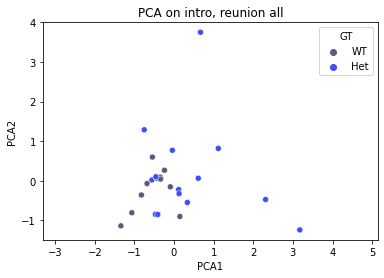

In [50]:
# ----- PARTNER DIRECTED BEHAVIORS, MALE -----

usesex = 'M'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','reunion']
assaybehavsx = [assay+'-'+name for name in homecagebehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
partnerpca = PCA(n_components=2,whiten=True)
partnercomp = partnerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(partnerpca.explained_variance_ratio_))
sliced['PCA1'] = partnercomp[:,0]
sliced['PCA2'] = partnercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, reunion all')

In [1]:
sliced

NameError: name 'sliced' is not defined

explained variance ratio (first two components): [0.39113243 0.2651185 ]


Text(0.5, 1.0, 'PCA on intro, reunion all')

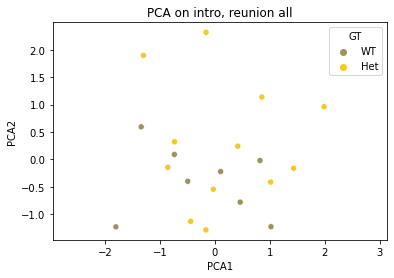

In [51]:
# ----- PARTNER DIRECTED BEHAVIORS, FEMALE -----

usesex = 'F'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','reunion']
assaybehavsx = [assay+'-'+name for name in homecagebehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
partnerpca = PCA(n_components=2,whiten=True)
partnercomp = partnerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(partnerpca.explained_variance_ratio_))
sliced['PCA1'] = partnercomp[:,0]
sliced['PCA2'] = partnercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, reunion all')

explained variance ratio (first two components): [0.42101807 0.23835377]


Text(0.5, 1.0, 'PCA on intro, aggression all')

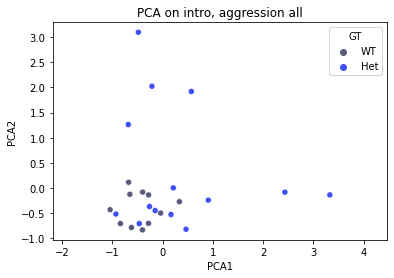

In [78]:
# ----- STRANGER DIRECTED BEHAVIORS, MALE -----

usesex = 'M'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','aggression']
assaybehavsx = [assay+'-'+name for name in homecagebehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(strangerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, aggression all')

explained variance ratio (first two components): [0.36959621 0.30986229]


Text(0.5, 1.0, 'PCA on intro, aggression all')

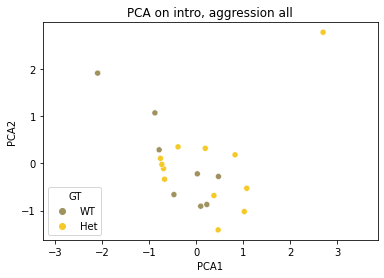

In [79]:
# ----- STRANGER DIRECTED BEHAVIORS, FEMALE -----

usesex = 'F'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','aggression']
assaybehavsx = [assay+'-'+name for name in homecagebehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(strangerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, aggression all')

In [71]:
prosocbehavs = ['Sniff','Investigate','Huddle']
agbehavs = ['Tussle','Strike','Defensive strike','Aggression receipt']
metrics = ['count']

explained variance ratio (first two components): [0.40622504 0.33137441]


Text(0.5, 1.0, 'PCA on intro, reunion, aggression prosocial')

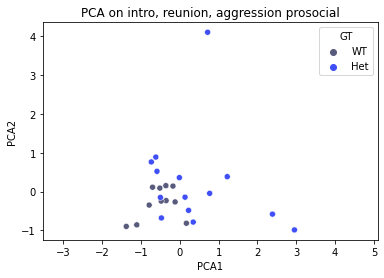

In [81]:
# ----- PROSOCIAL BEHAVIORS, MALE -----

usesex = 'M'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','reunion','aggression']
assaybehavsx = [assay+'-'+name for name in prosocbehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(strangerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, reunion, aggression prosocial')

explained variance ratio (first two components): [0.37104311 0.26765552]


Text(0.5, 1.0, 'PCA on intro, timed mating, reunion, aggression prosocial')

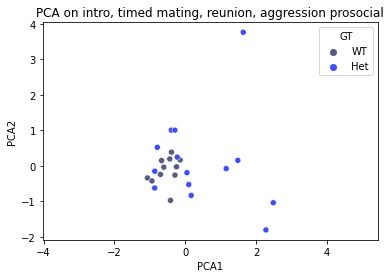

In [80]:
# ----- PROSOCIAL BEHAVIORS, MALE -----

usesex = 'M'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','timedMating','reunion','aggression']
assaybehavsx = [assay+'-'+name for name in prosocbehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(strangerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, timed mating, reunion, aggression prosocial')

explained variance ratio (first two components): [0.32766357 0.23352083]


Text(0.5, 1.0, 'PCA on intro, reunion, aggression prosocial')

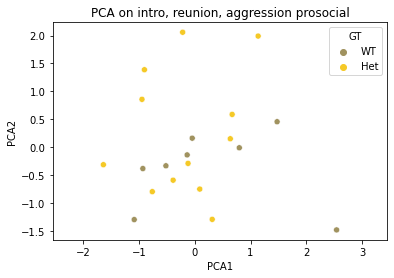

In [82]:
# ----- PROSOCIAL BEHAVIORS, FEMALE -----

usesex = 'F'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','reunion','aggression']
assaybehavsx = [assay+'-'+name for name in prosocbehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(strangerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, reunion, aggression prosocial')

explained variance ratio (first two components): [0.39113243 0.2651185 ]


Text(0.5, 1.0, 'PCA on intro, timed mating, reunion, aggression prosocial')

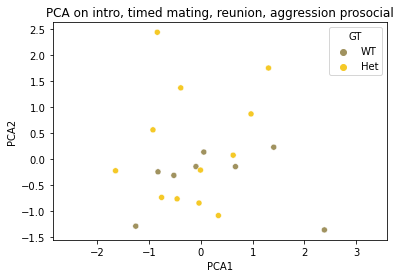

In [59]:
# ----- PROSOCIAL BEHAVIORS, FEMALE -----

usesex = 'F'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','timedMating','reunion','aggression']
assaybehavsx = [assay+'-'+name for name in prosocbehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(partnerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, timed mating, reunion, aggression prosocial')

explained variance ratio (first two components): [0.39113243 0.2651185 ]


Text(0.5, 1.0, 'PCA on intro, reunion, aggression agonistic')

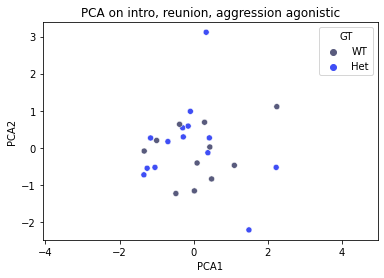

In [72]:
# ----- AGONISTIC BEHAVIORS, MALE -----

usesex = 'M'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','reunion','aggression']
assaybehavsx = [assay+'-'+name for name in agbehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(partnerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, reunion, aggression agonistic')

explained variance ratio (first two components): [0.39113243 0.2651185 ]


Text(0.5, 1.0, 'PCA on intro, timed mating, reunion, aggression agonistic')

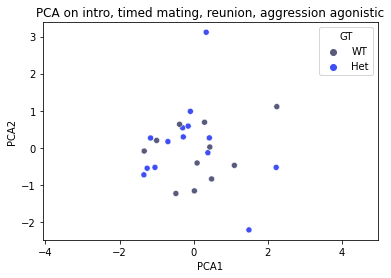

In [63]:
# ----- AGONISTIC BEHAVIORS, MALE -----

usesex = 'M'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','timedMating','reunion','aggression']
assaybehavsx = [assay+'-'+name for name in agbehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(partnerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, timed mating, reunion, aggression agonistic')

explained variance ratio (first two components): [0.39113243 0.2651185 ]


Text(0.5, 1.0, 'PCA on intro, reunion, aggression agonistic')

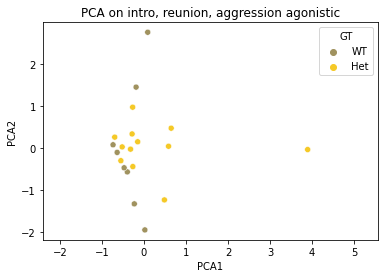

In [64]:
# ----- AGONISTIC BEHAVIORS, FEMALE -----

usesex = 'F'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','reunion','aggression']
assaybehavsx = [assay+'-'+name for name in agbehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(partnerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, reunion, aggression agonistic')

explained variance ratio (first two components): [0.39113243 0.2651185 ]


Text(0.5, 1.0, 'PCA on intro, timed mating, reunion, aggression agonistic')

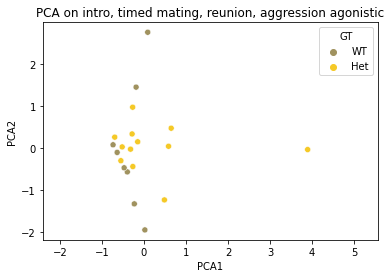

In [65]:
# ----- AGONISTIC BEHAVIORS, FEMALE -----

usesex = 'F'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','timedMating','reunion','aggression']
assaybehavsx = [assay+'-'+name for name in agbehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(partnerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, timed mating, reunion, aggression agonistic')

In [74]:
prosocbehavs = ['Sniff','Investigate','Huddle']
agbehavs = ['Tussle','Strike','Defensive strike','Aggression receipt']
metrics = ['median','count']

explained variance ratio (first two components): [0.39113243 0.2651185 ]


Text(0.5, 1.0, 'PCA on intro, reunion, aggression agonistic')

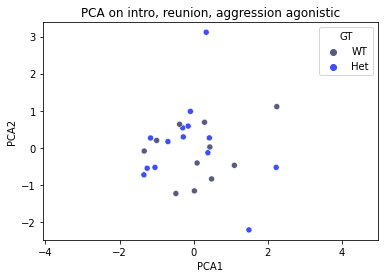

In [67]:
# ----- AGONISTIC BEHAVIORS, MALE -----

usesex = 'M'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','reunion','aggression']
assaybehavsx = [assay+'-'+name for name in agbehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(partnerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, reunion, aggression agonistic')

explained variance ratio (first two components): [0.39113243 0.2651185 ]


Text(0.5, 1.0, 'PCA on intro, timed mating, reunion, aggression agonistic')

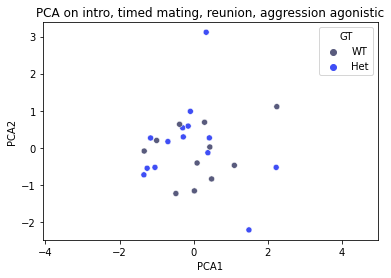

In [75]:
# ----- AGONISTIC BEHAVIORS, MALE -----

usesex = 'M'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','timedMating','reunion','aggression']
assaybehavsx = [assay+'-'+name for name in agbehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(partnerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, timed mating, reunion, aggression agonistic')

explained variance ratio (first two components): [0.39113243 0.2651185 ]


Text(0.5, 1.0, 'PCA on intro, reunion, aggression agonistic')

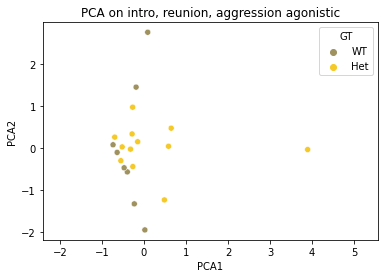

In [76]:
# ----- AGONISTIC BEHAVIORS, FEMALE -----

usesex = 'F'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','reunion','aggression']
assaybehavsx = [assay+'-'+name for name in agbehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(partnerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, reunion, aggression agonistic')

explained variance ratio (first two components): [0.39113243 0.2651185 ]


Text(0.5, 1.0, 'PCA on intro, timed mating, reunion, aggression agonistic')

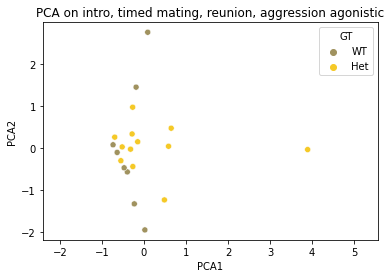

In [77]:
# ----- AGONISTIC BEHAVIORS, FEMALE -----

usesex = 'F'
if usesex == 'M':
    usepal = mpal
else:
    usepal = fpal

assays = ['introduction','timedMating','reunion','aggression']
assaybehavsx = [assay+'-'+name for name in agbehavs for assay in assays]
assaybehavst = [label+'-'+metric for metric in metrics for label in assaybehavsx]
assaybehavs = []
usecols = filled[filled.sex==usesex].columns
for i,label in enumerate(assaybehavst):
    if label in usecols:
        assaybehavs.append(label)
sliced = filled[filled.sex==usesex][assaybehavs]
strangerpca = PCA(n_components=2,whiten=True)
strangercomp = strangerpca.fit(sliced).transform(sliced)
print(
    "explained variance ratio (first two components): %s"
    % str(partnerpca.explained_variance_ratio_))
sliced['PCA1'] = strangercomp[:,0]
sliced['PCA2'] = strangercomp[:,1]
sliced['GT'] = filled.GT
tp = sns.scatterplot(data=sliced , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, timed mating, reunion, aggression agonistic')